# Homework 6 - Generative Adversarial Network
This is the sample code for hw6 of 2022 Machine Learning course in National Taiwan University. 

In this sample code, there are 5 sections:
1. Environment setting
2. Dataset preparation
3. Model setting
4. Train
5. Inference

Your goal is to do anime face generation, if you have any question, please discuss at NTU COOL 

# Environment setting
In this section, we will prepare for the dataset and set some environment variable

## Download Dataset

In [1]:
from google.colab import drive
import os
drive.mount('/content/drive')

##出現提示欄進行授權

os.chdir('/content/drive/My Drive/ML2/HW6/') #切換該目錄
os.listdir() #確認目錄內容



# get dataset from huggingface hub
!curl -s https://packagecloud.io/install/repositories/github/git-lfs/script.deb.sh | bash
!apt-get install git-lfs
!git lfs install
!git clone https://huggingface.co/datasets/LeoFeng/MLHW_6
!unzip ./MLHW_6/faces.zip -d .

Mounted at /content/drive
Detected operating system as Ubuntu/bionic.
Checking for curl...
Detected curl...
Checking for gpg...
Detected gpg...
Running apt-get update... done.
Installing apt-transport-https... done.
Installing /etc/apt/sources.list.d/github_git-lfs.list...done.
Importing packagecloud gpg key... done.
Running apt-get update... done.

The repository is setup! You can now install packages.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  git-lfs
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 6,800 kB of archives.
After this operation, 15.3 MB of additional disk space will be used.
Get:1 https://packagecloud.io/github/git-lfs/ubuntu bionic/main amd64 git-lfs amd64 3.1.2 [6,800 kB]
Fetched 6,800 kB in 3s (2,540 kB/s)
Selecting previously unselected package git-lfs.
(Reading database ... 155459 files and directories currently installed.)
Preparing to un

## Other setting

In [2]:
# import module
import os
import glob
import random
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch import optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import numpy as np
import logging
from tqdm import tqdm
import torch.autograd as autograd

# Stylegan2
!pip install stylegan2_pytorch

# seed setting
def same_seeds(seed):
    # Python built-in random module
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Torch
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

same_seeds(101)
workspace_dir = '.'

     |████████████████████████████████| 87 kB 5.3 MB/s 
     |████████████████████████████████| 493 kB 30.3 MB/s 
     |████████████████████████████████| 17.5 MB 21.8 MB/s 
     |████████████████████████████████| 53 kB 3.0 MB/s 
     |████████████████████████████████| 4.3 MB 47.5 MB/s 
     |████████████████████████████████| 280 kB 76.7 MB/s 
     |████████████████████████████████| 210 kB 65.2 MB/s 
     |████████████████████████████████| 51 kB 569 kB/s 
     |████████████████████████████████| 55 kB 5.4 MB/s 
     |████████████████████████████████| 5.1 MB 51.2 MB/s 
     |████████████████████████████████| 181 kB 80.8 MB/s 
     |████████████████████████████████| 4.0 MB 56.6 MB/s 
     |████████████████████████████████| 3.6 MB 61.7 MB/s 
     |████████████████████████████████| 503 kB 70.7 MB/s 
     |████████████████████████████████| 78 kB 9.4 MB/s 
     |████████████████████████████████| 10.9 MB 57.4 MB/s 
     |████████████████████████████████| 60 kB 10.5 MB/s 
     |█████████████████

# Dataset preparation
In this section, we prepare for the dataset for Pytorch

## Create dataset for Pytorch

In order to unified image information, we use the transform function to:
1. Resize image to 64x64
2. Normalize the image

This CrypkoDataset class will be use in Section 4

In [3]:
# prepare for CrypkoDataset

class CrypkoDataset(Dataset):
    def __init__(self, fnames, transform):
        self.transform = transform
        self.fnames = fnames
        self.num_samples = len(self.fnames)

    def __getitem__(self,idx):
        fname = self.fnames[idx]
        img = torchvision.io.read_image(fname)
        img = self.transform(img)
        return img

    def __len__(self):
        return self.num_samples

def get_dataset(root):
    fnames = glob.glob(os.path.join(root, '*'))
    compose = [
        transforms.ToPILImage(),
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ]
    transform = transforms.Compose(compose)
    dataset = CrypkoDataset(fnames, transform)
    return dataset

## Show the image
Show some sample in the dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


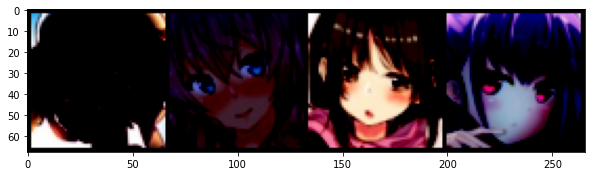

In [4]:
temp_dataset = get_dataset(os.path.join(workspace_dir, 'faces'))

images = [temp_dataset[i] for i in range(4)]
grid_img = torchvision.utils.make_grid(images, nrow=4)
plt.figure(figsize=(10,10))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

In [5]:
!stylegan2_pytorch --data ./faces --name stylegan256 --models_dir ./models --results_dir ./results --image-size 64 --num-train-steps 100000 --batch-size 2 --gradient-accumulate-every 8 --network-capacity 256

stylegan256<./faces>:   0% 50/100000 [03:32<117:55:08,  4.25s/it]G: 83.59 | D: 3.78 | GP: 13.21
stylegan256<./faces>:   0% 55/100000 [03:51<116:52:26,  4.21s/it]Traceback (most recent call last):
  File "/usr/local/bin/stylegan2_pytorch", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.7/dist-packages/stylegan2_pytorch/cli.py", line 190, in main
    fire.Fire(train_from_folder)
  File "/usr/local/lib/python3.7/dist-packages/fire/core.py", line 141, in Fire
    component_trace = _Fire(component, args, parsed_flag_args, context, name)
  File "/usr/local/lib/python3.7/dist-packages/fire/core.py", line 471, in _Fire
    target=component.__name__)
  File "/usr/local/lib/python3.7/dist-packages/fire/core.py", line 681, in _CallAndUpdateTrace
    component = fn(*varargs, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/stylegan2_pytorch/cli.py", line 181, in train_from_folder
    run_training(0, 1, model_args, data, load_from, new, num_train_steps, name, seed)


loading from version 1.8.8


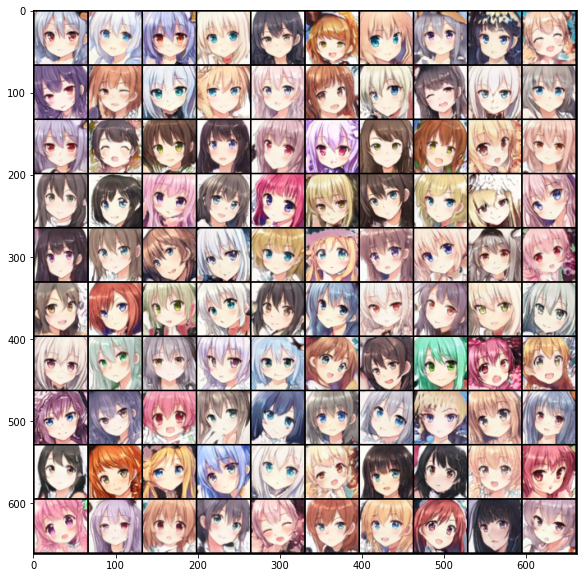

In [ ]:
import torch
from torchvision.utils import save_image
from stylegan2_pytorch import ModelLoader

loader = ModelLoader(
    base_dir = './',   
    name = 'stylegan2',
    load_from = 37                  
)


noise   = torch.randn(1000, 512).cuda() 
styles  = loader.noise_to_styles(noise, trunc_psi = 0.75)  
images  = loader.styles_to_images(styles[:100]) # 


grid_img = torchvision.utils.make_grid(images, nrow=10)
plt.figure(figsize=(10,10))
plt.imshow(grid_img.data.cpu().permute(1, 2, 0))
plt.show()


In [ ]:
os.makedirs('./output_stylegan_0.75/', exist_ok=True)
eval_batch_size = 25

for i in range(40):
    images = loader.styles_to_images(styles[i*eval_batch_size:(i+1)*eval_batch_size])
    for j in range(eval_batch_size):
        save_image(images[j], f'./output_stylegan_0.75/{i*eval_batch_size+j+1}.jpg') # save your images, or do whatever you desire

# Compress the images.
%cd output_stylegan_0.75
!tar -zcf ../submission.tgz *.jpg
%cd ..

/content/drive/MyDrive/ML2/HW6/output_stylegan_0.9
/content/drive/MyDrive/ML2/HW6
